In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Initial v:  Parameter containing:
tensor([1.8645], requires_grad=True)
Epoch 1, L2相对误差: 0.977536021067024, v: 1.8644566080121423
  loss: 2.132681
Epoch 1000, L2相对误差: 0.6754159808170961, v: 1.5440559730799623
  loss: 2.016820
Epoch 2000, L2相对误差: 0.5690551076352223, v: 1.9224650312864524
  loss: 1.999356
Epoch 3000, L2相对误差: 0.5863923575547777, v: 2.102466859185004
  loss: 1.995302
Epoch 4000, L2相对误差: 0.5550095248661672, v: 2.2179289731545953
  loss: 1.972514
Epoch 5000, L2相对误差: 0.5549343558078959, v: 2.2859153544616904
  loss: 2.006745
Epoch 6000, L2相对误差: 0.5446953036168612, v: 2.3526686106116244
  loss: 2.018981
Epoch 7000, L2相对误差: 0.535510416987228, v: 2.4339119258464383
  loss: 1.949629
Epoch 8000, L2相对误差: 0.5384079038664964, v: 2.507175369488114
  loss: 1.974275
Epoch 9000, L2相对误差: 0.5196713284510608, v: 2.554620557496032
  loss: 1.998742
Epoch 10000, L2相对误差: 0.509855711235267, v: 2.622392981449914
  loss: 1.917848
Epoch 11000, L2相对误差: 0.5168628439372167, v: 2.656089686908908
  loss:

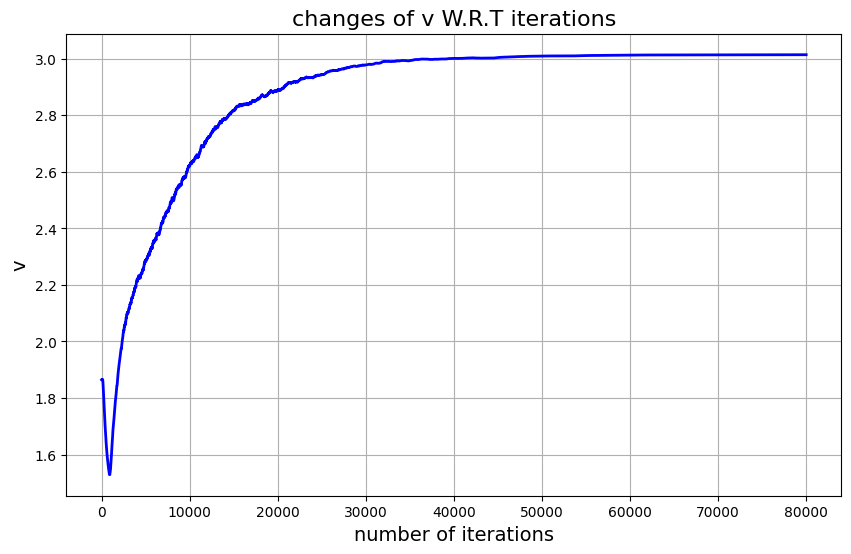

In [ ]:
#BCE loss(Tumor Growth real data)
import torch
import numpy as np
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

sin = torch.sin
cos = torch.cos
exp = torch.exp
pi = torch.pi
torch.set_default_dtype(torch.float64)

epochs = 80000  # iterations
h = 100  # Test point grid density
N = 2000  # interior points
N1 = 100  # boundary points
N2 = 200  # data points

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)

setup_seed(123456)

def gen_testdata():
    data = np.load("/content/drive/MyDrive/2D_RS_Real_1_t.npz")


    t, x, y, usol = data["t"], data["x"], data["y"], data["u_sol"]
    xx, yy, tt = np.meshgrid(x, y, t)
    X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(tt))).T
    z = usol.flatten()[:, None]
    return X, z

def l2_relative_error(z_true, z_pred):
    return np.linalg.norm(z_true - z_pred) / np.linalg.norm(z_true)

# Domain and Sampling
def interior(n=N):
    # sampling x∈[-3,3], y∈[-3,3], t∈[0,1]
    x = torch.rand(n, 1)*6 - 3  # [-3,3]
    y = torch.rand(n, 1)*6 - 3  # [-3,3]
    t = torch.rand(n, 1)        # [0,1]
    cond = torch.zeros_like(t)
    return x.requires_grad_(True), y.requires_grad_(True), t.requires_grad_(True), cond

def ini(n=N1):
    # IC t=0
    x = torch.rand(n, 1)*6 - 3
    y = torch.rand(n, 1)*6 - 3
    t = torch.zeros_like(x)
    cond = torch.where(x**2+y**2<0.25, torch.full_like(x,1), torch.zeros_like(x))
    return x.requires_grad_(True), y.requires_grad_(True), t.requires_grad_(True), cond

def left(n=N1):
    # BC u(-3,y,t)=0
    t = torch.rand(n, 1)
    x = -3 * torch.ones_like(t)
    y = torch.rand(n, 1)*6 - 3
    cond = torch.zeros_like(t)
    return x.requires_grad_(True),y.requires_grad_(True), t.requires_grad_(True), cond

def right(n=N1):
    # BC u(3,y,t)=0
    t = torch.rand(n, 1)
    x = 3 * torch.ones_like(t)
    y = torch.rand(n, 1)*6 - 3
    cond = torch.zeros_like(t)
    return x.requires_grad_(True),y.requires_grad_(True), t.requires_grad_(True), cond

def up(n=N1):
    # BC u(x,3,t)=0
    t = torch.rand(n, 1)
    y = 3 * torch.ones_like(t)
    x = torch.rand(n, 1)*6 - 3
    cond = torch.zeros_like(t)
    return x.requires_grad_(True), y.requires_grad_(True),t.requires_grad_(True), cond

def down(n=N1):
    # BC u(x,-3,t)=0
    t = torch.rand(n, 1)
    y = -3 * torch.ones_like(t)
    x = torch.rand(n, 1)*6 - 3
    cond = torch.zeros_like(t)
    return x.requires_grad_(True),y.requires_grad_(True), t.requires_grad_(True), cond

def data_interior(n=N2):
    # data
    X, Y = gen_testdata()
    ids = np.random.randint(X.shape[0], size=n)
    xy_t = X[ids]
    u_real = Y[ids]
    xy_t = torch.from_numpy(xy_t)
    cond = torch.from_numpy(u_real)
    xy_t.requires_grad_(True)
    return xy_t, cond

# Neural Network
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(3, 64),  # input: x,y,t
            torch.nn.Tanh(),
            torch.nn.Linear(64, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 1),
        )

    def forward(self, x):
        features = self.net(x)
        u_val = torch.clamp(features, min=0.0, max=5.0)
        u_bce = torch.sigmoid(u_val)
        return u_val, u_bce



# Loss functions
loss = torch.nn.MSELoss()
bce_loss_fn = torch.nn.BCELoss()

def gradients(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                 create_graph=True,
                                 only_inputs=True)[0]
    else:
        return gradients(gradients(u, x), x, order=order-1)

v = torch.nn.Parameter(torch.randn(1), requires_grad=True)

print('Initial v: ', v)

def l_interior(u):
    x, y, t, cond = interior()

    u_val, _ = u(torch.cat([x, y, t], dim=1))
    u_t = gradients(u_val, t, 1)
    u_x = gradients(u_val, x, 1)
    u_y = gradients(u_val, y, 1)
    u_xx = gradients(u_val, x, 2)
    u_yy = gradients(u_val, y, 2)

    residual = u_t - 6*u_val*(u_x**2+u_y**2)-3*(u_val**2)*(u_xx + u_yy) - v*u_val
    return loss(residual, cond)

def l_ini(u):
    # IC loss
    x, y, t, cond = ini()
    u_val, _ = u(torch.cat([x, y, t], dim=1))
    return loss(u_val, cond)

def l_left(u):
    # BC loss
    x, y, t, cond = left()
    u_val, _ = u(torch.cat([x, y, t], dim=1))
    return loss(u_val, cond)

def l_right(u):
    # BC loss
    x, y, t, cond = right()
    u_val, _ = u(torch.cat([x, y, t], dim=1))
    return loss(u_val, cond)

def l_up(u):
    # BC loss
    x, y, t, cond = up()
    u_val, _ = u(torch.cat([x, y, t], dim=1))
    return loss(u_val, cond)

def l_down(u):
    # BC loss
    x, y, t, cond = down()
    u_val, _ = u(torch.cat([x, y, t], dim=1))
    return loss(u_val, cond)

def l_data(u):
    xyt, cond = data_interior()
    _, u_bce = u(xyt)  # BCE
    cond_binary = cond.clamp(0, 1)
    return bce_loss_fn(u_bce, cond_binary)



# Training

u = MLP()
opt = torch.optim.RAdam(list(u.parameters()) + [v], lr=1e-3)

scheduler = StepLR(opt, step_size=1000, gamma=0.9)


# record training
L2_error = []
v_values = []
iterations = []

# obtain training data
xy_t, u_real = gen_testdata()
xy_t = torch.from_numpy(xy_t)

for i in range(epochs):
    opt.zero_grad()
    l_i = l_interior(u)
    l_d = l_data(u)
    l_initial = l_ini(u)
    l_u = l_up(u)
    l_dn = l_down(u)
    l_l = l_left(u)
    l_r = l_right(u)
    # loss function
    l = l_i + l_initial + l_dn + l_u + l_l + l_r + 3*l_data(u)
    l.backward()

    torch.nn.utils.clip_grad_norm_(u.parameters(), 0.1)

    opt.step()

    scheduler.step()

    # record
    v_values.append(v.item())
    iterations.append(i+1)

    if (i+1) % 1000 == 0 or i == 0:
        u_pred, _ = u(xy_t)
        error = l2_relative_error(u_real, u_pred.detach().numpy())
        L2_error.append(error)
        print(f"Epoch {i+1}, L2 Relative Error: {error}, v: {v.item()}")
        print(f"  loss: {l.item():.6f}")


print('Final v: ', v)
plt.figure(figsize=(10, 6))
plt.plot(iterations, v_values, 'b-', linewidth=2)
plt.xlabel('number of iterations', fontsize=14)
plt.ylabel('v', fontsize=14)
plt.title('changes of v W.R.T iterations', fontsize=16)
plt.grid(True)
plt.show()